In [1]:
import glob
import unicodedata
import string
import requests
import random
import sys
import torch
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import random
import time
import math
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters)

def letterToIndex(letter):
    index = all_letters.find(letter)
    if index == -1:
        index = all_letters.find('')
    return index

def findFiles(path): return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

github_url = 'https://api.github.com/repos/DrUzair/NLP/contents/data/names'
branch = 'f8e0c40481b1c1e32440b1da39c8bdfc9f070ffa'

all_categories = []
category_lines = {}

response = requests.get(f'{github_url}?ref={branch}')

if response.status_code == 200:
    file_data = response.json()

    for file_info in file_data:
        if file_info['type'] == 'file' and file_info['name'].endswith('.txt'):
            file_url = file_info['download_url']
            category = file_info['name'].split('.')[0]

            all_categories.append(category)

            file_response = requests.get(file_url)

            if file_response.status_code == 200:
                lines = file_response.text.split('\n')
                category_lines[category] = lines
            else:
                print(f"Failed to download file: {file_info['name']}")
else:
    print(f"Failed to retrieve file list from GitHub: {response.status_code}")

n_categories = len(all_categories)

In [46]:

print(all_categories)
print(len(all_categories))
     

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
18


In [ ]:
class NameDataset(Dataset):
    def __init__(self, category_lines, all_categories):
        self.category_lines = category_lines
        self.all_categories = all_categories
        self.data = []
        self.labels = []
        self.max_len = max([len(line) for lines in category_lines.values() for line in lines])
        self.prepare_data()

    def prepare_data(self):
        for category in self.all_categories:
            for line in self.category_lines[category]:
                self.data.append(line)
                self.labels.append(self.all_categories.index(category))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        name_idx = [letterToIndex(char) for char in name]
        name_idx = name_idx + [letterToIndex('')] * (self.max_len - len(name_idx))
        return torch.tensor(name_idx), torch.tensor(label)

In [ ]:

def inspect_dataloader(dataloader):
    for i, (names, labels) in enumerate(dataloader):
        print(f"Batch {i+1}")
        print("Names (indices):", names)
        print("Labels:", labels)
        if i >= 0:
            break

In [ ]:
dataset = NameDataset(category_lines, all_categories)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

def inspect_dataloader(dataloader):
    for i, (names, labels) in enumerate(dataloader):
        print(f"Batch {i+1}")
        print("Names (indices):", names)
        print("Labels:", labels)
        print("Names Shape:", names.shape)
        if torch.any(names >= n_letters) or torch.any(names < 0):
            print("Error: Found indices out of range")
            print(names)
            break
        if i >= 2:
            break

inspect_dataloader(dataloader)

Batch 1
Names (indices): tensor([[27,  4, 17,  4, 25, 13,  8, 10, 14, 21,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0],
        [44,  0, 17, 19,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0],
        [27,  0,  3, 12,  0,  4, 21,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0],
        [38,  8,  2,  7,  0, 11, 14, 21,  8,  2,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0],
        [33,  0,  9,  4, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0],
        [26,  6, 14, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0],
        [33, 14, 10, 20, 18,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0],
        [43,  8,  2,  2,  7,  4, 19, 19,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0],
        [29, 14, 21,  6, 24,  0, 11, 11, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0],
        [32,  0, 13,  8, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
   

In [50]:

class NameClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, max_len):
        super(NameClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc = nn.Linear(embed_dim * max_len, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [51]:

def train_model(model, dataloader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for names, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(names)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')

In [ ]:
dataset = NameDataset(category_lines, all_categories)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


max_len = dataset.max_len
vocab_size = len(all_letters)
embed_dim = 16
num_classes = n_categories
max_len = dataset.max_len

model = NameClassifier(vocab_size, embed_dim, num_classes, max_len)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

train_model(model, dataloader, criterion, optimizer, num_epochs)

Epoch 1, Loss: 1.4564970229651517
Epoch 2, Loss: 1.1598604416391651
Epoch 3, Loss: 1.057650044323153
Epoch 4, Loss: 1.0021590802604985
Epoch 5, Loss: 0.9672463157564212
Epoch 6, Loss: 0.9413902547898566
Epoch 7, Loss: 0.9222131330211452
Epoch 8, Loss: 0.9063091596030886
Epoch 9, Loss: 0.8945581888317302
Epoch 10, Loss: 0.8853654226489888
Epoch 11, Loss: 0.8739718755434274
Epoch 12, Loss: 0.8669327101225306
Epoch 13, Loss: 0.8582617304032776
Epoch 14, Loss: 0.8531157946225943
Epoch 15, Loss: 0.8475436124547272
Epoch 16, Loss: 0.8420240344705096
Epoch 17, Loss: 0.8373255665135232
Epoch 18, Loss: 0.8326157826906556
Epoch 19, Loss: 0.8291121782960406
Epoch 20, Loss: 0.826729956610947


In [ ]:
import torch

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for names, labels in dataloader:
            outputs = model(names)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    print(f'Evaluation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

    return avg_loss, accuracy

# Example usage:
dataset = NameDataset(category_lines, all_categories)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

criterion = nn.CrossEntropyLoss()
evaluate_model(model, dataloader, criterion)

Evaluation Loss: 0.8008, Accuracy: 0.7413


(0.800824762766908, 0.7413398367509456)

In [ ]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable

def evaluate(line_tensor):
    model.eval()
    with torch.no_grad():
        output = model(line_tensor)
    return output

def predict(model, name, n_predictions=3):
    name_idx = [letterToIndex(char) for char in name]
    name_idx = name_idx + [letterToIndex('')] * (max_len - len(name_idx))
    name_tensor = torch.tensor(name_idx).unsqueeze(0).long()

    logits = evaluate(Variable(name_tensor))
    probabilities = F.softmax(logits, dim=1)

    topv, topi = probabilities.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i].item()
        category_index = topi[0][i].item()
        predictions.append((value, all_categories[category_index]))

    return predictions

name = 'Hamad'
predictions = predict(model, name, n_predictions=3)
for value, category in predictions:
    print(f'({value:.2f}) {category}')


(0.44) English
(0.31) Russian
(0.08) German


Confusion Matrix:
[[1681    0    0    0  138    0    0    0    0   15  120    0    0    0
    47    0    0    0]
 [  25  162    0    0   23    0    0    0    2    3   16   15    0    0
     9    0    0   14]
 [  25    1   86    3  170    0   29    1    1   12   18    0    8    1
   157    0    6    2]
 [  12    2   14   46  126    0   28    2    4    7    9    0    0    0
    48    0    0    0]
 [ 156   23   55    5 2792   15   79    7   27   48   44    6    2    2
   393    2   12    1]
 [  25    0    1    1  141   39    9    3    2   24    6    0    0    0
    27    0    0    0]
 [  56    7   17    5  296    2  227    3    1    7    9    1    1    0
    91    0    1    1]
 [  12    0    3    3   42    1    1  104    0    6    9    0    0    1
    22    0    0    0]
 [  15    0    3    0   81    1    1    0   95    6    7    0    0    0
    24    0    0    0]
 [  45    3    5    1  121    3    4    2    4  413   24    1    0    1
    68    0   15    0]
 [ 131    4    2    0   75    0 

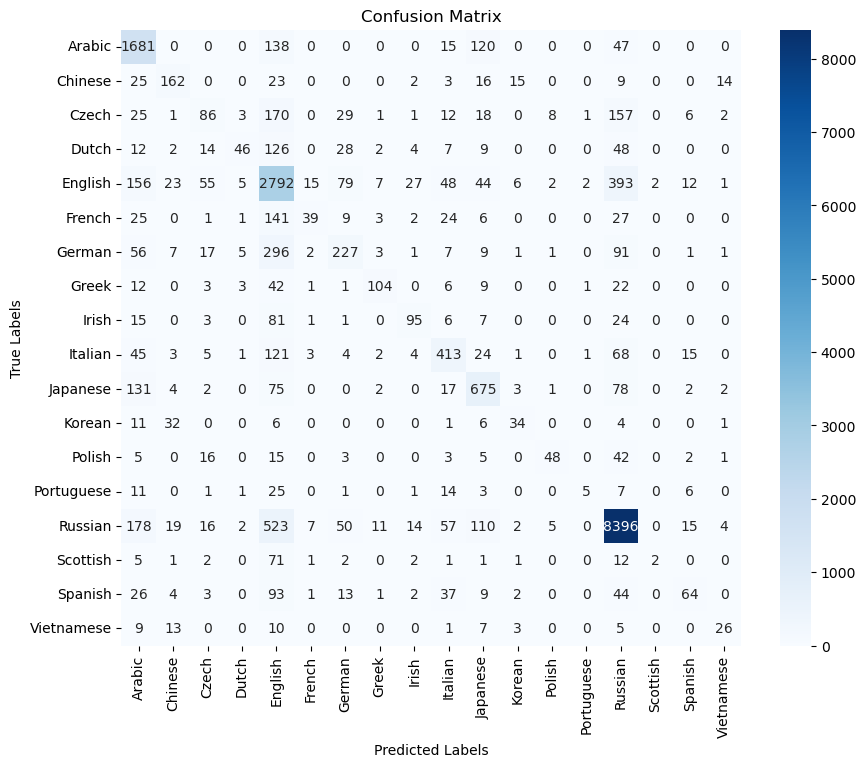

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, dataloader):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for names, labels in dataloader:
            outputs = model(names) 
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

def plot_confusion_matrix(true_labels, pred_labels, classes):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

classes = all_categories
pred_labels, true_labels = evaluate_model(model, dataloader)

print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=classes))

plot_confusion_matrix(true_labels, pred_labels, classes)
